In [2]:
# import helper
import pandas as pd
from utils import *
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch import nn
from IPython.display import Image
import torch
from torch import nn
from torch.utils.data import Dataset
import pennylane as qml
import torch.optim as optim
import torch.utils.data as data
import random
import tensorflow as tf

In [3]:
tf.random.set_seed(15)
torch.manual_seed(42)
random.seed(42)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams.update({'font.size':20})
legend_prop = {'weight':'bold'}
from pylab import rcParams
rcParams['axes.linewidth'] = 2

## Data : We use the same data as used on Classical solutions

In [4]:
df = pd.read_csv('Processed_data.csv')
df = df.drop([ 'Unnamed: 0'], axis=1)
# Initial dataframe has few rows which has zeros for features like "SMA_7" etc and hence removing few top rows
df=df[50:]
# Remove few redundant data
df=df.drop(columns=['Date'])
df=df.drop(columns=['CUMLOGRET_1'])
df=df.drop(columns=['Gold in USD volume'])
df=df.drop(columns=['Open'])
df=df.drop(columns=['High'])
df=df.drop(columns=['Low'])

In [5]:
# Set target and features
target = "Close"
features = list(df.columns.difference(["Close"]))
print(features)
print(len(features))

['3M', 'BBB_20_2.0', 'BBL_20_2.0', 'BBM_20_2.0', 'BBP_20_2.0', 'BBU_20_2.0', 'Close_copy', 'Crude Futures_close', 'Crude Futures_volume', 'Crude_H-L', 'Crude_O-C', 'EMA_14', 'EMA_21', 'EMA_7', 'FTSE_H-L', 'FTSE_O-C', 'GBP USD ', 'GBP_USD_H-L', 'GBP_USD_O-C', 'Gold in USD close', 'Gold_H-L', 'Gold_O-C', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'SMA_14', 'SMA_21', 'SMA_7', 'Volume']
29


In [6]:
target_mean = df[target].mean()
target_stdev = df[target].std()

for c in df.columns:
    mean = df[c].mean()
    stdev = df[c].std()

    df[c] = (df[c] - mean) / stdev

In [7]:
sequence_length = 60
window =10

def create_dataset(dataset,target,features, lookback, window):
    X_store, y_store = [], []
    for i in range(0,len(dataset)-lookback-window,2):
        X = (dataset[features].values)[i:i+lookback]
        y = (dataset[target].values)[i+lookback:i+lookback+window]
        X_store.append(X)
        y_store.append(y)
    return np.array(X_store), np.array(y_store)

In [8]:
# Split train test data
from sklearn.model_selection import train_test_split
# df_train, df_test = train_test_split(df, test_size=0.05)
size=int(len(df)*0.96)
df_train=df[:size]
df_test=df[size:]
print('Total sample', len(df))
print('Train sample', len(df_train))
print('Test sample', len(df_test))

Total sample 3208
Train sample 3079
Test sample 129


In [9]:
# Train data
X_train, y_train = create_dataset(
    df_train,
    target=target,
    features=features,
    lookback=sequence_length, window=window)

indices = tf.range(start=0, limit=tf.shape(X_train)[0])
shuffled_indices = tf.random.shuffle(indices)
X_train = tf.gather(X_train, shuffled_indices)
y_train = tf.gather(y_train, shuffled_indices)

print(X_train.shape, y_train.shape)

(1505, 60, 29) (1505, 10)


In [10]:
# Test data
X_test, y_test = create_dataset(
    df_test,
    target=target,
    features=features,
    lookback=sequence_length, window=window)

print(X_test.shape, y_test.shape)

(30, 60, 29) (30, 10)


# Proposed Approach

In [11]:
from tensorflow.keras import regularizers, initializers
from keras.layers import Input, Dense, Reshape, Embedding, concatenate, Dropout, Flatten
from keras.layers.merge import Dot
from keras.preprocessing import sequence
from keras import Model
from keras.layers.advanced_activations import PReLU
import tensorflow as tf

In [12]:
input_ = Input((60,29)) # feature
print(input_.shape)
den1=Dense(20, use_bias=True,activation=PReLU() )(input_)
print(den1.shape)
den2=Flatten()(den1)
print(den2.shape)
den3=Dense(96, use_bias=True,activation=PReLU()  )(den2)
print(den3.shape)
den4=Dense(64, use_bias=True,activation=PReLU()  )(den3)
print(den4.shape)
den5=Dense(10, use_bias=True,activation=PReLU() )(den4)
print(den5.shape)
model = Model(inputs=[input_], outputs=den5)

(None, 60, 29)
(None, 60, 20)
(None, 1200)
(None, 96)
(None, 64)
(None, 10)


In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 29)]          0         
                                                                 
 dense (Dense)               (None, 60, 20)            1800      
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense_1 (Dense)             (None, 96)                115392    
                                                                 
 dense_2 (Dense)             (None, 64)                6272      
                                                                 
 dense_3 (Dense)             (None, 10)                660       
                                                                 
Total params: 124,124
Trainable params: 124,124
Non-trainable

In [14]:
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(opt, loss=loss_fn)

In [15]:
model_history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                   batch_size=10, 
                   epochs=400, shuffle=True
                   )

Epoch 1/400
151/151 [==============================] - 1s 3ms/step - loss: 0.2935 - val_loss: 0.0604
Epoch 2/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0794 - val_loss: 0.0792
Epoch 3/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0578 - val_loss: 0.0431
Epoch 4/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0493
Epoch 5/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0435
Epoch 6/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0631
Epoch 7/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0520
Epoch 8/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0429
Epoch 9/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0506
Epoch 10/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0229 - val_lo

151/151 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0336
Epoch 82/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0387
Epoch 83/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0367
Epoch 84/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0362
Epoch 85/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0415
Epoch 86/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0401
Epoch 87/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0375
Epoch 88/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0384
Epoch 89/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0362
Epoch 90/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 

151/151 [==============================] - 0s 2ms/step - loss: 8.9559e-04 - val_loss: 0.0421
Epoch 161/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0426
Epoch 162/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0428
Epoch 163/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0405
Epoch 164/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0447
Epoch 165/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0413
Epoch 166/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0413
Epoch 167/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0453
Epoch 168/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0428
Epoch 169/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0011

151/151 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0450
Epoch 240/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0441
Epoch 241/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0439
Epoch 242/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0452
Epoch 243/400
151/151 [==============================] - 0s 2ms/step - loss: 9.6967e-04 - val_loss: 0.0414
Epoch 244/400
151/151 [==============================] - 0s 2ms/step - loss: 9.0959e-04 - val_loss: 0.0461
Epoch 245/400
151/151 [==============================] - 0s 2ms/step - loss: 9.5284e-04 - val_loss: 0.0415
Epoch 246/400
151/151 [==============================] - 0s 2ms/step - loss: 9.3000e-04 - val_loss: 0.0430
Epoch 247/400
151/151 [==============================] - 0s 2ms/step - loss: 7.0884e-04 - val_loss: 0.0443
Epoch 248/400
151/151 [==============================] - 0s 2ms/ste

151/151 [==============================] - 0s 2ms/step - loss: 7.3441e-04 - val_loss: 0.0451
Epoch 318/400
151/151 [==============================] - 0s 2ms/step - loss: 7.3166e-04 - val_loss: 0.0443
Epoch 319/400
151/151 [==============================] - 0s 2ms/step - loss: 8.3703e-04 - val_loss: 0.0444
Epoch 320/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0434
Epoch 321/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0473
Epoch 322/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0424
Epoch 323/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0421
Epoch 324/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0421
Epoch 325/400
151/151 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0428
Epoch 326/400
151/151 [==============================] - 0s 2ms/step - loss

Epoch 395/400
151/151 [==============================] - 0s 2ms/step - loss: 9.6231e-04 - val_loss: 0.0386
Epoch 396/400
151/151 [==============================] - 0s 2ms/step - loss: 7.2835e-04 - val_loss: 0.0457
Epoch 397/400
151/151 [==============================] - 0s 2ms/step - loss: 9.2319e-04 - val_loss: 0.0407
Epoch 398/400
151/151 [==============================] - 0s 2ms/step - loss: 9.7093e-04 - val_loss: 0.0412
Epoch 399/400
151/151 [==============================] - 0s 2ms/step - loss: 7.8122e-04 - val_loss: 0.0377
Epoch 400/400
151/151 [==============================] - 0s 2ms/step - loss: 9.0917e-04 - val_loss: 0.0428


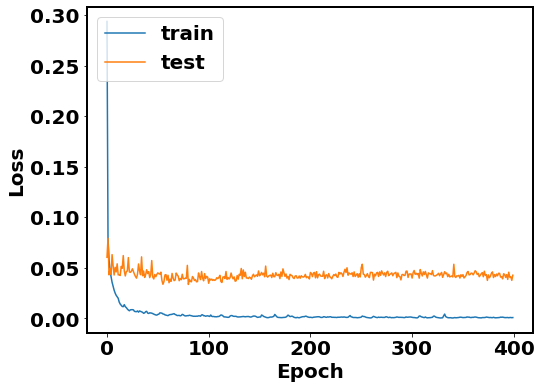

In [16]:
import keras
from matplotlib import pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
def cal_metrics(y_true,y_pred):
    mae=0
    rmse=0
    for i in range(len(y_true)):
        y1=y_true[i]* target_stdev + target_mean
        y2=y_pred[i]* target_stdev + target_mean
        mae=mean_absolute_error(y1, y2)+mae
        rmse=mean_squared_error(y1, y2, squared=False)+rmse  
    return mae/len(y_true) , rmse/len(y_true)

In [18]:
def mae_metric(actual, predicted):
    sum_error = 0.0
    for i in range(len(actual)):
        sum_error += abs(predicted[i] - actual[i])
    return sum_error/len(actual)

def rmse_metric(actual, predicted):
    sum_error = 0.0
    for i in range(len(actual)):
        sum_error += (predicted[i] - actual[i])**2
    return (sum_error/len(actual))**0.5

In [19]:
mae_train_pros, rmse_train_pros= cal_metrics(y_train,model.predict(X_train))
print('MAE train error is',mae_train_pros)
print('RMSE train error is',rmse_train_pros)

mae_test_pros, rmse_test_pros= cal_metrics(y_test,model.predict(X_test))
print('MAE test error is',mae_test_pros)
print('RMSE test error is',rmse_test_pros)

MAE train error is 15.236158232973434
RMSE train error is 18.207249133757117
MAE test error is 101.10738491753474
RMSE test error is 119.53918686060926


In [20]:
# The unknown data
X_check=(df_train[features].values)[len(df_train)-sequence_length:len(df_train)]
y_check=(df_test[target].values)[:window]

In [21]:
y_ann_pred = model.predict(np.array([X_check]))
x1=y_ann_pred*target_stdev + target_mean
x2=y_check*target_stdev + target_mean

In [22]:
print('MAE Error',mae_metric(x1[0], x2) )
print('RMSE error',rmse_metric(x1[0], x2) )

MAE Error 84.34868359375005
RMSE error 91.52495371798298


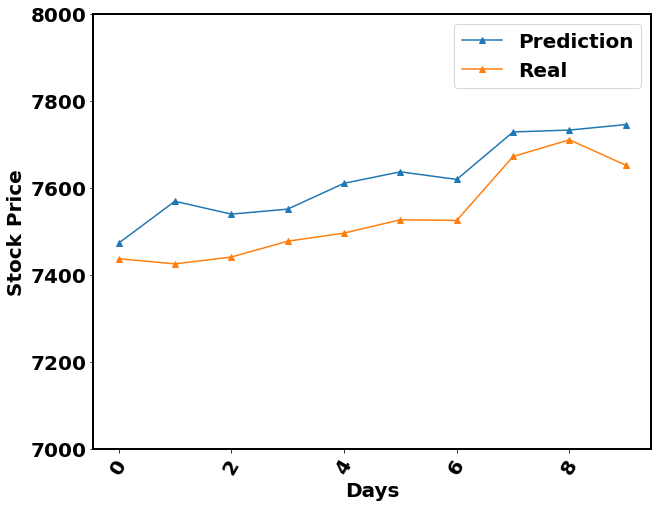

In [23]:
plt.figure(figsize=(10, 8))
plt.plot( x1[0], label = "Prediction",marker='^')
plt.plot( x2, label = "Real",marker='^')
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.xticks(rotation=60)
plt.ylim(7000, 8000) 
plt.legend()
plt.show()

In [24]:
def accuracy(y_true, y_pred, threshold):
    c=0
    for i in range(len(y_true)):
        if abs(y_true[i]-y_pred[i])<threshold:
            c=c+1
    return c/len(y_true)

In [25]:
accuracy(x1[0], x2,80)

0.4

In [26]:
for k in range(len(X_test)):
    y_k = model.predict(np.array([X_test[k]]))
    x1_k=y_k*target_stdev + target_mean
    x2_k=y_test[k]*target_stdev + target_mean
    print('MAE Error',mae_metric(x1_k[0], x2_k) )

MAE Error 61.456265625000015
MAE Error 98.18334765625005
MAE Error 74.61091601562484
MAE Error 48.75329492187493
MAE Error 47.587820312500206
MAE Error 81.53786458333343
MAE Error 57.49178710937504
MAE Error 37.776521484375095
MAE Error 34.45844726562509
MAE Error 42.049191406249975
MAE Error 79.11533333333337
MAE Error 128.99773437500008
MAE Error 124.25428124999999
MAE Error 138.47660546875005
MAE Error 170.50048046875
MAE Error 200.8311855468749
MAE Error 115.33815820312502
MAE Error 153.0316171875
MAE Error 133.36265429687492
MAE Error 76.73844531249998
MAE Error 131.12398046874995
MAE Error 114.45709765625006
MAE Error 70.95308203124996
MAE Error 74.3542031250001
MAE Error 82.58064062500007
MAE Error 88.2881992187502
MAE Error 92.0665722656252
MAE Error 92.93053710937511
MAE Error 215.47017578125005
MAE Error 166.44554687500005
